In [41]:
import os
import re
import json
import heapq
import nltk
import spacy
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS 

nlp_data= ''
traversed_files = []
nlp = spacy.load("en_core_web_sm")
punctuations = '!"#$%&\'()*+,-/:;<=>?@[\\]^_`{|}~©'

REQUIRED_KEY = 'text'
STOPWORDS = stopwords.words('english')
READ_SAVED_FILE = '/kaggle/input/covid-data/clean_data.txt'
WRITE_OUTPUT_FILE = '/kaggle/working/result.txt'



In [42]:

def write_file(nlp_data):
    """ 
    Write clean data  and  save it result.txt file . 
    """
    with open(WRITE_OUTPUT_FILE,'w+') as f:
        for line in nlp_data:
            f.write(line)
            
def read_file():
    """ 
    Read clean data  from the saved file.
    """
    count=0
    with open(READ_SAVED_FILE,'r') as f:
        data = f.read()
    return data

In [43]:

def process_file():
    """
    Call this function to get the data from the kaggle data . The resultant data will be stored to 
    """
    count=0
    FILE_COUNT = 9
    for dirname, _, filenames in os.walk('/kaggle/input/'):
        for filename in filenames:
            if(filename.endswith('json') and count <=FILE_COUNT and filename not in traversed_files):
                count+=1
                traversed_files.append(filename)
                with open(os.path.join(dirname, filename)) as data :
                    data = json.load(data)
                    get_data_from_files_recursively(data)
                    
    write_file(nlp_data)
    # Any results you write to the current directory are saved as output in result.txt file.

In [44]:
def get_data_from_files_recursively(obj): 
    """
    Read the input file and extract specific data based on the specific key in the json . 
    """
    if type(obj) is dict:
        for key,value in obj.items():
            if(key== REQUIRED_KEY):
                global nlp_data
                nlp_data+=value
            get_data_from_files_recursively(obj[key])
    elif type(obj) is list: 
        for each in obj:
            get_data_from_files_recursively(each)
    else:
        return     
    

In [45]:
def cleanup_text(docs, logging=False):
    """
        Tokenize the data and remove the stop words . 
    """    
    texts = []
    sentence_list=[]
    
    docs =   docs.replace("\n", "") # We dont need to understand the line breaks.Thus removing     
    doc = nlp(docs)
#     tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
    for idx, sentence in enumerate(doc.sents): # we are using spacy for sentence tokenization
        sentence_list.append(re.sub(r'[^\w\s]','',str(sentence)))
    
    tokens = [tok for tok in sentence_list if tok not in STOPWORDS and tok not in punctuations]
    return ''.join(tokens)


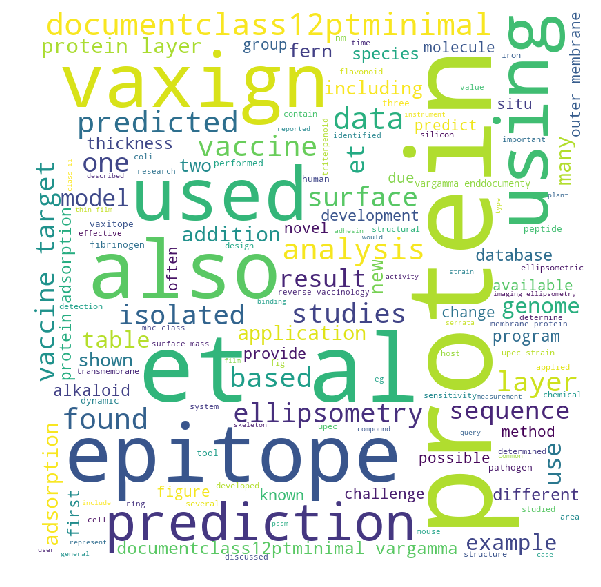

In [46]:
def show_word_cloud(data):
    tokens = data.split()
    stopwords = set(STOPWORDS) 
    stopwords.add('may')
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(' '.join(tokens)) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 
    return wordcloud
show_word_cloud(cleanup_text(read_file()[:100000]))

In [47]:
def generate_summary(text_without_removing_dot, cleaned_text):
    """
    1. create a word frequency probability list 
    2. On the basis of max frequencey of words filter the sentences which has these words .
    """
    doc = nlp(text_without_removing_dot)
    cleaned_text = cleaned_text.split()
    word_frequencies = {}  

    for word in cleaned_text:  
        if word not in word_frequencies.keys():
            word_frequencies[word] = 1
        else:
            word_frequencies[word] += 1
    maximum_frequncy = max(word_frequencies.values())

    for word in word_frequencies.keys():  
        word_frequencies[word] = (word_frequencies[word]/maximum_frequncy) 
    
    #as we need actual sentences we need to parse initial_data before cleanup
    sentence_scores = {} 
    frequency_keys=  list(word_frequencies.keys())
    for sent in doc.sents:
        for word in str(sent):
            if word in frequency_keys:
                if sent not in sentence_scores.keys():
                    sentence_scores[sent] = word_frequencies[word]
                else:
                    sentence_scores[sent] += word_frequencies[word]
    
    tup = list(sentence_scores.items())
    tup.sort(key = lambda x: x[1],reverse=True)  
    return tup


In [48]:
initial_text = read_file()[:100000]
cleaned_text = cleanup_text(initial_text)
tup = generate_summary(initial_text,cleaned_text)
result=''.join([str(tup[i][0]) for i in range(8) ])


In [49]:
result

'Pharmacological and ethnopharmacological studies have revealed that substances in ferns exhibit diverse pharmacological effects such as cytotoxicity (Radhika et al. 2010), hepatoprotective activity (Wills and Asha 2006), antihyperglycemic activity (Zheng et al. 2011a, b), leishmanicidal activity (Socolsky et al. 2015), trypanocidal activity (Morais-Braga et al. 2013a, b), anti-nociceptive activity, anti-inflammatory activity (Yonathan et al. 2006), immunomodulatory activity (Wu et al. 2005), and chemopreventive effects (Wills and Asha 2009).(2007) reported the isolation of three new phenolic compounds in aqueous extracts of this species: kaempferol 3-O-l-rhamnopyranoside-7-O-[-d-apio-furanosyl-(1-2)-O-d-glucopyranoside], 7-O-caffeoylhydroxymaltol 3-O-d-glucopyranoside and hispidin 4-O-d-glucopyranoside, along with the known compounds kaempferol 3-O-l-rhamnopyranoside-7-O-d-glucopyranoside, caffeic acid, 5-caffeoylquinic acid, 3,5-di-caffeoylquinic acid, and 4,5-di-caffeoylquinic acid.

1. 